## Building an Implied Vol Surface from Deribit ETH Option Price Data

In [1]:
# import modules
import json
import requests
import pandas as pd
from tqdm import tqdm
import sqlite3
import numpy as np
import datetime
from datetime import datetime as dt
import py_vollib_vectorized
import py_vollib
import matplotlib.pyplot as plt

#### Get the ETH option price data from Deribit

In [2]:
def get_option_name_and_settlement(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: 2 lists:
                        1.  list of traded options for the selected coin;
                        2.  list of settlement period for the selected coin.
    """

    # requests public API
    # r = requests.get("https://test.deribit.com/api/v2/public/get_instruments?currency=" + coin + "&kind=option")
    r = requests.get("https://www.deribit.com/api/v2/public/get_instruments?currency=" + coin + "&kind=option")
    result = json.loads(r.text)

    # get option name
    name = pd.json_normalize(result['result'])['instrument_name']
    name = list(name)

    # get option settlement period
    settlement_period = pd.json_normalize(result['result'])['settlement_period']
    settlement_period = list(settlement_period)

    return name, settlement_period


def get_option_data(coin):
    """
    :param coin: crypto-currency coin name ('BTC', 'ETH')
    :return: pandas data frame with all option data for a given coin
    """

    # get option name and settlement
    coin_name = get_option_name_and_settlement(coin)[0]
    settlement_period = get_option_name_and_settlement(coin)[1]

    # initialize data frame
    coin_df = []

    # initialize progress bar
    pbar = tqdm(total=len(coin_name))

    # loop to download data for each Option Name
    for i in range(len(coin_name)):
        # download option data -- requests and convert json to pandas
        # r = requests.get('https://test.deribit.com/api/v2/public/get_order_book?instrument_name=' + coin_name[i])
        r = requests.get('https://www.deribit.com/api/v2/public/get_order_book?instrument_name=' + coin_name[i])
        result = json.loads(r.text)
        df = pd.json_normalize(result['result'])

        # add settlement period
        df['settlement_period'] = settlement_period[i]

        # append data to data frame
        coin_df.append(df)

        # update progress bar
        pbar.update(1)

    # finalize data frame
    coin_df = pd.concat(coin_df)

    # remove useless columns from coin_df
    columns = ['state', 'estimated_delivery_price']
    coin_df.drop(columns, inplace=True, axis=1)

    # close the progress bar
    pbar.close()

    return coin_df


# print data and time for log
print('Date and time: ' +  datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + ' , format: dd/mm/yyyy hh:mm:ss')

# download data -- ETH Options
eth_data = get_option_data('ETH')

# export data to .csv -- append to existing
eth_data.to_csv('../eth_option_data.csv', index=0, mode='a', header=True)

# transform each element of the data frames into strings for sqlite3
eth_data = eth_data.astype(str)

# connect to the SQLite3 database -- option_data.db
conn = sqlite3.connect('option-data.db')
print('Connection established with SQLite3 server: option-data.db')

# create/update ETH tables in the database
eth_data.to_sql(name='eth_option_data', con=conn, if_exists='append', chunksize=None, index=False)
print('ETH data appended')

Date and time: 09/01/2023 09:20:19 , format: dd/mm/yyyy hh:mm:ss


100%|██████████| 514/514 [02:08<00:00,  3.99it/s]


Connection established with SQLite3 server: option-data.db
ETH data appended


#### Select Columns Needed

In [3]:
eth_mod = eth_data[["underlying_price", "instrument_name", "best_bid_price", "best_ask_price"]]
print(eth_mod.head())

  underlying_price    instrument_name best_bid_price best_ask_price
0        1322.0109  ETH-10JAN23-600-C            0.0            0.0
0        1322.0109  ETH-10JAN23-600-P            0.0         0.0005
0        1322.0529  ETH-10JAN23-700-C            0.0            0.0
0        1322.0529  ETH-10JAN23-700-P            0.0         0.0005
0        1322.0529  ETH-10JAN23-800-C            0.0            0.0


#### Extract Strike, Option Type, and Expiry from "instrument_name" Column

In [4]:
''' https://www.programiz.com/python-programming/datetime/strptime '''

eth_mod = eth_mod.assign(strike = eth_mod["instrument_name"].str.split("-").apply(lambda x: x[-2]))
eth_mod = eth_mod.assign(call_or_put = eth_mod["instrument_name"].str.split("-").apply(lambda x: x[-1]))
eth_mod = eth_mod.assign(expiry = eth_mod["instrument_name"].str.split("-").apply(lambda x: x[-3])) 
eth_mod["expiry"] = eth_mod["expiry"].apply(lambda x: dt.strptime(x, '%d%b%y').date())  

eth_mod["underlying_price"] = eth_mod["underlying_price"].apply(lambda x: float(x))
eth_mod["best_bid_price"] = (eth_mod["best_bid_price"]).astype(float) * eth_mod["underlying_price"]
eth_mod["best_ask_price"] = (eth_mod["best_ask_price"]).astype(float) * eth_mod["underlying_price"]

eth_mod

,underlying_price,instrument_name,best_bid_price,best_ask_price,strike,call_or_put,expiry
0,1322.0109,ETH-10JAN23-600-C,0.00000,0.000000,600,C,2023-01-10
0,1322.0109,ETH-10JAN23-600-P,0.00000,0.661005,600,P,2023-01-10
0,1322.0529,ETH-10JAN23-700-C,0.00000,0.000000,700,C,2023-01-10
0,1322.0529,ETH-10JAN23-700-P,0.00000,0.661026,700,P,2023-01-10
0,1322.0529,ETH-10JAN23-800-C,0.00000,0.000000,800,C,2023-01-10
...,...,...,...,...,...,...,...
0,1323.9700,ETH-29DEC23-3500-P,0.00000,0.000000,3500,P,2023-12-29
0,1323.9600,ETH-29DEC23-4000-C,18.53544,23.831280,4000,C,2023-12-29
0,1323.9600,ETH-29DEC23-4000-P,0.00000,0.000000,4000,P,2023-12-29
0,1323.9600,ETH-29DEC23-4500-C,13.90158,19.859400,4500,C,2023-12-29


#### Derive Time to Expiry

In [5]:
eth_mod = eth_mod.assign(yrs_to_exp = (pd.to_datetime(eth_mod["expiry"]) - dt.now()).astype("timedelta64[D]")/365)
print(type(eth_mod["yrs_to_exp"]))
eth_mod = eth_mod.assign(risk_free = 0.01)
# eth_mod


<class 'pandas.core.series.Series'>


#### Derive Market Mid Price of Options

In [6]:
eth_mod = eth_mod.assign(market_mid_price = (eth_mod["best_bid_price"].astype(float) + eth_mod["best_ask_price"].astype(float)) / 2)
eth_mod = eth_mod.assign(imp_vol = 0)
# eth_mod

#### Derive Implied Volatility from Option Price

In [7]:
for i in range(len(eth_mod)):
    price = eth_mod["market_mid_price"].iloc[i]
    S = float(eth_mod["underlying_price"].iloc[i])
    K = float(eth_mod["strike"].iloc[i])
    t = eth_mod["yrs_to_exp"].iloc[i]
    r = eth_mod["risk_free"].iloc[i]
    if str(eth_mod["call_or_put"].iloc[i]) == "C":
        flag = "c"
    elif str(eth_mod["call_or_put"].iloc[i]) == "P":
        flag = "p" 

    if price != 0 and t > 1/365:
        eth_mod["imp_vol"].iloc[i] = py_vollib.black_scholes_merton.implied_volatility.implied_volatility(price, S, K, t, r, flag, q=0, return_as='numpy')
    else: 
        eth_mod["imp_vol"].iloc[i] = 0

eth_mod

/var/folders/3z/w6c9_t2j3qx69rnc_bp69fjh0000gn/T/ipykernel_60007/3499097850.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_mod["imp_vol"].iloc[i] = 0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/var/folders/3z/w6c9_t2j3qx69rnc_bp69fjh0000gn/T/ipykernel_60007/3499097850.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_mod["imp_vol"].iloc[i] = py_v

,underlying_price,instrument_name,best_bid_price,best_ask_price,strike,call_or_put,expiry,yrs_to_exp,risk_free,market_mid_price,imp_vol
0,1322.0109,ETH-10JAN23-600-C,0.00000,0.000000,600,C,2023-01-10,0.000000,0.01,0.000000,0.000000
0,1322.0109,ETH-10JAN23-600-P,0.00000,0.661005,600,P,2023-01-10,0.000000,0.01,0.330503,0.000000
0,1322.0529,ETH-10JAN23-700-C,0.00000,0.000000,700,C,2023-01-10,0.000000,0.01,0.000000,0.000000
0,1322.0529,ETH-10JAN23-700-P,0.00000,0.661026,700,P,2023-01-10,0.000000,0.01,0.330513,0.000000
0,1322.0529,ETH-10JAN23-800-C,0.00000,0.000000,800,C,2023-01-10,0.000000,0.01,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
0,1323.9700,ETH-29DEC23-3500-P,0.00000,0.000000,3500,P,2023-12-29,0.967123,0.01,0.000000,0.000000
0,1323.9600,ETH-29DEC23-4000-C,18.53544,23.831280,4000,C,2023-12-29,0.967123,0.01,21.183360,0.630420
0,1323.9600,ETH-29DEC23-4000-P,0.00000,0.000000,4000,P,2023-12-29,0.967123,0.01,0.000000,0.000000
0,1323.9600,ETH-29DEC23-4500-C,13.90158,19.859400,4500,C,2023-12-29,0.967123,0.01,16.880490,0.652206


#### Use Strikes, Years to Expiry, and Implied Volatilities to Build Vol Surface

In [8]:
# Remove rows without option price bid and offers and with strikes too close to expiry (negative time)
eth_surface = eth_mod[(eth_mod["best_bid_price"].astype(float) > 0.0001) & (eth_mod["best_ask_price"].astype(float) > 0.0001) & (eth_mod["yrs_to_exp"] >= 1/365)]
eth_surface = eth_surface[["strike", "yrs_to_exp", "imp_vol"]]
eth_surface

,strike,yrs_to_exp,imp_vol
0,1050,0.002740,0.000000
0,1100,0.002740,0.000000
0,1150,0.002740,0.000000
0,1175,0.002740,0.000000
0,1200,0.002740,0.000000
...,...,...,...
0,2500,0.967123,0.622212
0,3000,0.967123,0.621656
0,3500,0.967123,0.625349
0,4000,0.967123,0.630420


#### Plot the ETH Implied Vol Surface

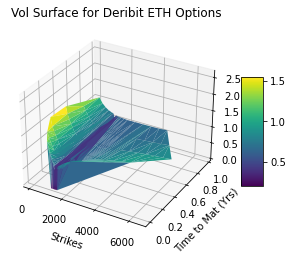

In [9]:
x_axis = eth_surface["strike"].astype(float)
y_axis = eth_surface["yrs_to_exp"]
z_axis = eth_surface["imp_vol"]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf=ax.plot_trisurf(x_axis, y_axis, z_axis, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Vol Surface for Deribit ETH Options")
plt.xlabel("Strikes")
plt.ylabel("Time to Mat (Yrs)")
plt.show()